## Goal of the project Binary Classification

* only use Binary Classification Problems.
* Recall that we are using amazon review data to predict album ratings. More specifically, we want to see if a product review is over or under a certain threshold. For this problem, we say that an album is "awesome" if its average rating is over 4.5 (not inclusive). Otherwise, the product is "not awesome". The data is not given to us with a binary 1(over)/0(under) column.
Many products in the training file will have more than one review. 
* Thus, we need to find the average overall score for a product.
Groupby aggregates columns with the same values for you to then perform an operation on the aggregated columns.

In [ ]:
# Load dataset from Github
import requests, zipfile, io
r = requests.get('https://github.com/charliecarver/cosc247/blob/master/datasets.zip?raw=true') 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
testPath = 'Test.csv'
trainPath = 'Train.csv'

In [ ]:
# import of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import sklearn.model_selection
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.tree
import sklearn.linear_model
from sklearn.metrics import classification_report, confusion_matrix


## Data load

In [ ]:
# load data and see what data type has
df = pd.read_csv(trainPath)
backup_df = df.copy()
df.dtypes

reviewerID              int64
amazon-id               int64
helpful                object
unixReviewTime          int64
reviewText             object
overall                 int64
reviewTime             object
summary                object
price                 float64
categories             object
root-genre             object
title                   int64
artist                  int64
label                  object
first-release-year    float64
songs                  object
salesRank               int64
related                object
dtype: object

In [1]:
df.info()

NameError: name 'df' is not defined

In [ ]:
# helpful feature mapped into float number by transforming the fraction
# this changes denominator 0 case into NaN
df['helpful_transformed'] = df['helpful'].apply(lambda x: np.nan if literal_eval(x)[1]== 0 else literal_eval(x)[0]/literal_eval(x)[1])

In [ ]:
# before root-genre encoding
df['root-genre'].value_counts()

Pop                   47313
Rock                  21874
Classical              6879
Latin Music            6867
Country                4454
Jazz                   4021
Dance & Electronic     4020
Alternative Rock       2797
New Age                2693
Rap & Hip-Hop          2423
Folk                   2260
Metal                  2258
R&B                    1709
Blues                   630
Gospel                  600
Reggae                  300
Name: root-genre, dtype: int64

## Data distribution found

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36263e9b00>,
      dtype=object)

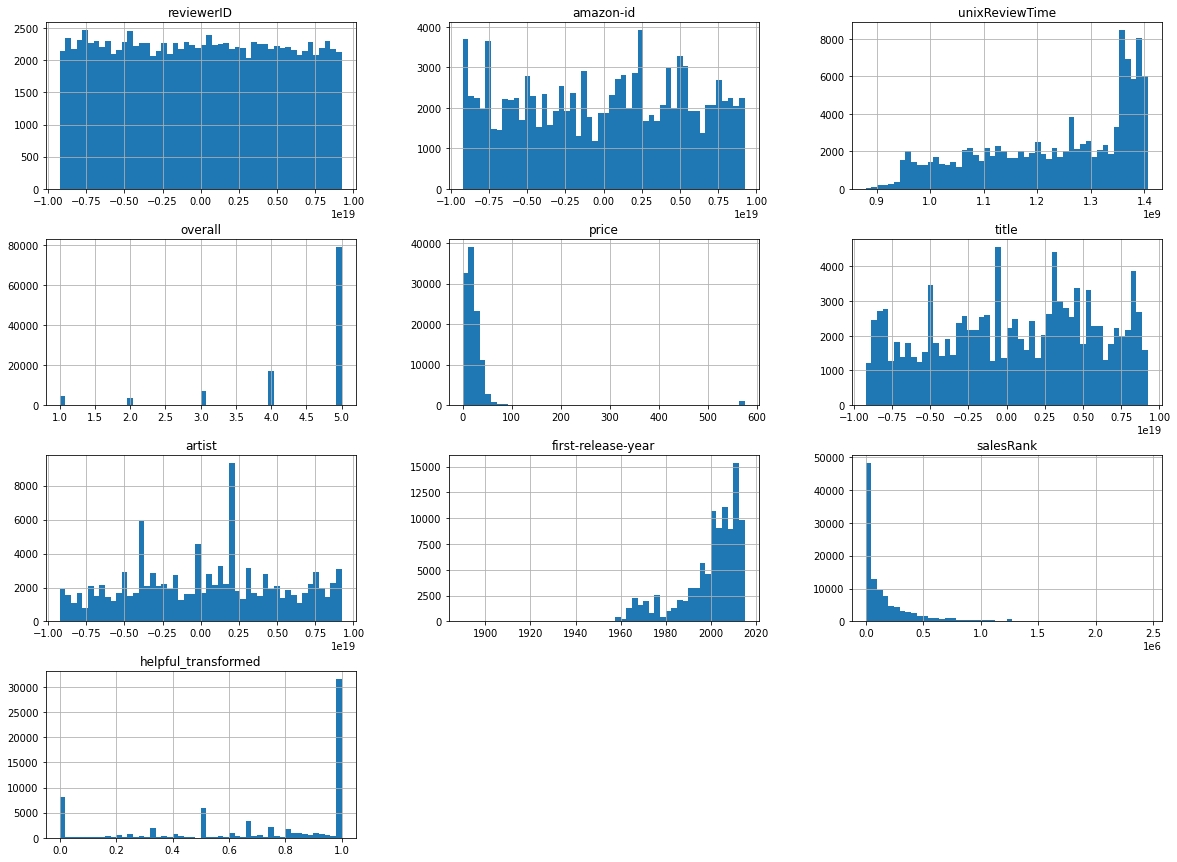

In [ ]:
# histogram
df.hist(bins=50,figsize=(20,15))

In [ ]:
# Pearson correlation for overall and other (entire)
corr_matrix = df.corr()
corr_matrix['overall'].sort_values(ascending=False)

overall                1.000000
helpful_transformed    0.334707
unixReviewTime         0.049034
amazon-id              0.014093
title                  0.009592
reviewerID             0.003343
price                 -0.013251
salesRank             -0.014595
first-release-year    -0.019243
artist                -0.026578
Name: overall, dtype: float64

## Data pre-processing

### one hot encoding

In [ ]:
# One hot encoding
# haven't done for processing with this in the algorithm yet
df['root-genre'] = df['root-genre'].astype('category')
root_genre_cat = df['root-genre']
root_genre_cat_encoded, root_genre_categories = root_genre_cat.factorize()
encoder = OneHotEncoder(categories='auto')
root_genre_cat_1hot = encoder.fit_transform(root_genre_cat_encoded.reshape(-1,1))
root_genre_cat_1hot.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
genre_dummies = pd.get_dummies(df['root-genre'])
genre_dummies

,Alternative Rock,Blues,Classical,Country,Dance & Electronic,Folk,Gospel,Jazz,Latin Music,Metal,New Age,Pop,R&B,Rap & Hip-Hop,Reggae,Rock
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111093,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
111094,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
111095,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
111096,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### drop NaN data

In [ ]:
# drop both
df_drop_all = df.dropna(subset=["helpful_transformed", "first-release-year"])
df_drop_all.describe()

,reviewerID,amazon-id,unixReviewTime,overall,price,title,artist,first-release-year,salesRank,helpful_transformed
count,6.231400e+04,6.231400e+04,6.231400e+04,62314.000000,62314.000000,6.231400e+04,6.231400e+04,62314.000000,6.231400e+04,62314.000000
mean,-5.738829e+16,-1.082026e+17,1.189015e+09,4.317409,20.332644,5.170977e+17,3.964111e+17,1998.487595,2.181048e+05,0.704545
std,5.320430e+18,5.459479e+18,1.351383e+08,1.162616,17.024350,5.220645e+18,4.901873e+18,13.578413,3.598565e+05,0.354257
min,-9.223209e+18,-9.217724e+18,8.794656e+08,1.000000,0.250000,-9.219330e+18,-9.220220e+18,1890.000000,6.000000e+00,0.000000
25%,-4.673797e+18,-5.002316e+18,1.078704e+09,4.000000,9.990000,-3.841314e+18,-3.758738e+18,1994.000000,8.876000e+03,0.500000
50%,-7.116225e+16,4.131612e+17,1.193443e+09,5.000000,16.260000,8.119961e+17,7.017061e+17,2003.000000,8.517000e+04,0.866667
75%,4.533849e+18,4.620256e+18,1.308852e+09,5.000000,27.520000,4.742375e+18,4.215883e+18,2009.000000,2.596760e+05,1.000000
max,9.222415e+18,9.222653e+18,1.405901e+09,5.000000,486.730000,9.220934e+18,9.218510e+18,2015.000000,2.453642e+06,1.000000


In [ ]:
# function define for normalization and standardization
def normalize_column_data(column):
    return (column-column.min())/(column.max()-column.min())

def standardize_column_data(column):
    return (column-column.mean())/column.std()

In [ ]:
# normalization
# warning message no problem. ignore
df_drop_all['price'] = normalize_column_data(df_drop_all['price'])
df_drop_all['salesRank'] = normalize_column_data(df_drop_all['salesRank'])
df_drop_all['first-release-year'] = normalize_column_data(df_drop_all['first-release-year'])
df_drop_all['unixReviewTime'] = normalize_column_data(df_drop_all['unixReviewTime'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

### predict target column make

In [ ]:
df_drop_all['predict_target'] = 0
df_drop_all['predict_target'][df_drop_all['overall'] >= 4] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [ ]:
# see the data
df_drop_all.head()

,reviewerID,amazon-id,helpful,unixReviewTime,reviewText,overall,reviewTime,summary,price,categories,root-genre,title,artist,label,first-release-year,songs,salesRank,related,helpful_transformed,predict_target
30,-3029154682982670675,2828769427501176858,"[13, 13]",0.750369,When I was in Music School at Stetson Universi...,5,"05 22, 2010",A Great Teaching tool,0.030320,"['CDs & Vinyl', 'Classical', 'Sacred & Religio...",Classical,-3686601028207514605,-1412275221690118390,Solesmes,0.896,"[-5278554366520980165, 1031059927497114547, -8...",0.070053,"{'also_bought': [-2564721328448647001, 4039811...",1.0,1
32,-84902388281572817,1683355681609577463,"[0, 1]",0.980469,After seeing this selling on line for as much ...,4,"03 24, 2014",Metallica - Death Magnetic (Deluxe Coffin Boxset),0.205024,"['CDs & Vinyl', 'Rock']",Rock,2278261453371246336,1178076565539150448,Mercury (Universal),0.944,"[6232524707980398149, 5566973718179316922, -43...",0.205259,"{'also_viewed': [-5109793234044987754, 5931663...",0.0,1
33,-8209243714021876578,245546254853962888,"[1, 1]",0.395043,Let me start by saying that I am not a die-har...,5,"06 17, 2004",Best Comedy Recording Ever,0.075481,"['CDs & Vinyl', 'Dance & Electronic']",Dance & Electronic,-3282866979189163366,8493232817338375900,Enigma,0.800,"[-5143272649889793807, -547543979015767703, -8...",0.081436,"{'also_bought': [5334117667833916410, 27299936...",1.0,1
35,-7466026974335812302,245546254853962888,"[10, 10]",0.482357,"If you've got a taste for Sandra, it never got...",5,"12 1, 2005",CLASSIC PERFORMANCE,0.075481,"['CDs & Vinyl', 'Dance & Electronic']",Dance & Electronic,-3282866979189163366,8493232817338375900,Enigma,0.800,"[-5143272649889793807, -547543979015767703, -8...",0.081436,"{'also_bought': [5334117667833916410, 27299936...",1.0,1
36,-4626832404357630738,245546254853962888,"[2, 2]",0.767766,As audio needs to deliver imagery and laughs t...,4,"09 5, 2010","""Oh mi GOSH... there must've been dust, on tho...",0.075481,"['CDs & Vinyl', 'Dance & Electronic']",Dance & Electronic,-3282866979189163366,8493232817338375900,Enigma,0.800,"[-5143272649889793807, -547543979015767703, -8...",0.081436,"{'also_bought': [5334117667833916410, 27299936...",1.0,1


### Text and Unnecessary Data Drop

In [ ]:
df_drop_all.drop(['helpful', 'reviewText', 'overall', 'summary', 'categories', 'root-genre', 'label', 'reviewTime'], axis=1)

# only using data for quant analysis
feature_names = ["unixReviewTime", "price", "first-release-year", "salesRank", "helpful_transformed"]
# candidate later: "songs", "related", "title", "reviewerID", "amazon-id", 
quant_data = df_drop_all[feature_names]
predicted_variable = df_drop_all['predict_target']

quant_data.head()

,unixReviewTime,price,first-release-year,salesRank,helpful_transformed
30,0.750369,0.030320,0.896,0.070053,1.0
32,0.980469,0.205024,0.944,0.205259,0.0
33,0.395043,0.075481,0.800,0.081436,1.0
35,0.482357,0.075481,0.800,0.081436,1.0
36,0.767766,0.075481,0.800,0.081436,1.0


## Train and Test Models

In [ ]:
# train and test data split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(quant_data, predicted_variable, test_size=0.4)

In [ ]:
# GNB
print("Trying gaussian naive bayes")
gnb = sklearn.naive_bayes.GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred)))
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying gaussian naive bayes
F1 score: 0.8719679392533222
accuracy score: 0.7808312605311722
[[  860  3577]
 [ 1886 18603]]
              precision    recall  f1-score   support

           0       0.31      0.19      0.24      4437
           1       0.84      0.91      0.87     20489

    accuracy                           0.78     24926
   macro avg       0.58      0.55      0.56     24926
weighted avg       0.75      0.78      0.76     24926



In [ ]:
# Decision tree
print("Trying a decision tree")
clf = sklearn.tree.DecisionTreeClassifier(max_depth=4)
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred)))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying a decision tree
F1 score: 0.9093806819457226
accuracy score: 0.8380406001765225
[[  633  3804]
 [  233 20256]]
              precision    recall  f1-score   support

           0       0.73      0.14      0.24      4437
           1       0.84      0.99      0.91     20489

    accuracy                           0.84     24926
   macro avg       0.79      0.57      0.57     24926
weighted avg       0.82      0.84      0.79     24926



In [ ]:
# stochastic
print("Trying SGD model")
SGD_clf = sklearn.linear_model.SGDClassifier(max_iter=1000, random_state=42)
y_pred = SGD_clf.fit(X_train, y_train).predict(X_test)
#SGD_clf.score(X_test, y_test)
print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred)))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying SGD model
F1 score: 0.9023010018716282
accuracy score: 0.8219930995747412
[[    0  4437]
 [    0 20489]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4437
           1       0.82      1.00      0.90     20489

    accuracy                           0.82     24926
   macro avg       0.41      0.50      0.45     24926
weighted avg       0.68      0.82      0.74     24926



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Trying Support Vector Machine with linear")
svm_clf = SVC(kernel="linear", C=1)
y_pred = svm_clf.fit(X_train, y_train).predict(X_test)
print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred)))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying Support Vector Machine with linear
F1 score: 0.9023010018716282
accuracy score: 0.8219930995747412
[[    0  4437]
 [    0 20489]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4437
           1       0.82      1.00      0.90     20489

    accuracy                           0.82     24926
   macro avg       0.41      0.50      0.45     24926
weighted avg       0.68      0.82      0.74     24926



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
